JOBSHEET 03:  
TEKNIK REGRESI GAMBAR


Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    # radius acak
    r = np.random.randint(min_r, max_r + 1)

    # buat canvas hitam
    img = np.zeros((img_size, img_size), dtype=np.uint8)

    # posisi pusat lingkaran
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y

    # gambar lingkaran putih terisi
    cv2.circle(img, (cx, cy), r, (255,), -1)

    # normalisasi ke [0,1]
    img = (img / 255.0).astype(np.float32)

    # ubah ke 3-channel agar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)

    return img3, float(r), (cx, cy)

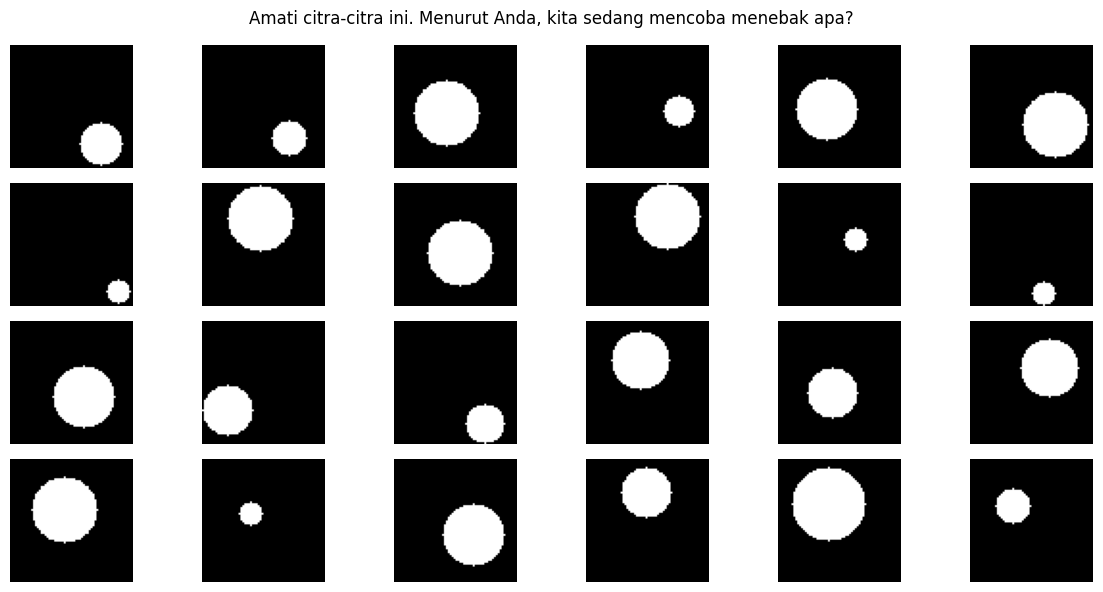

In [25]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]

imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

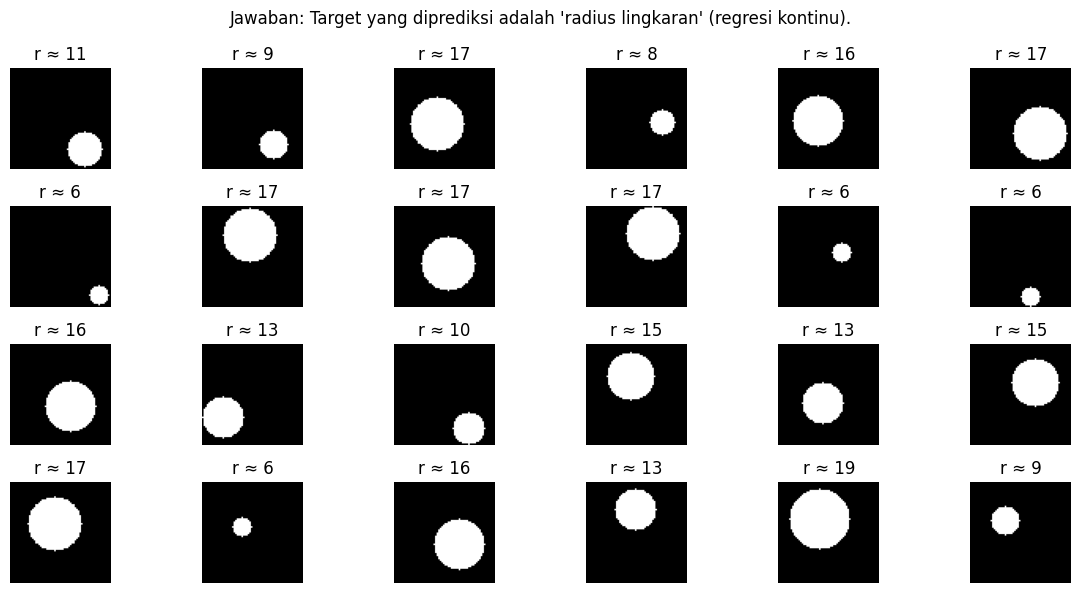

In [26]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

In [27]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Split train dan test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MAE=0.936 | RMSE=1.157 | R²=0.935


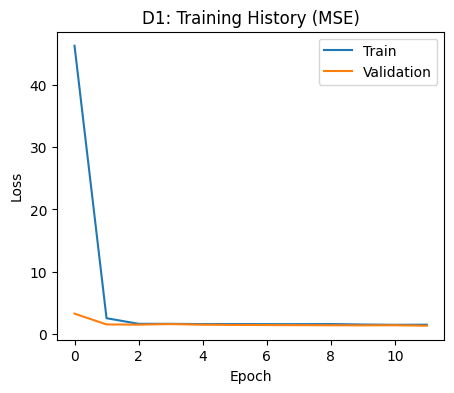

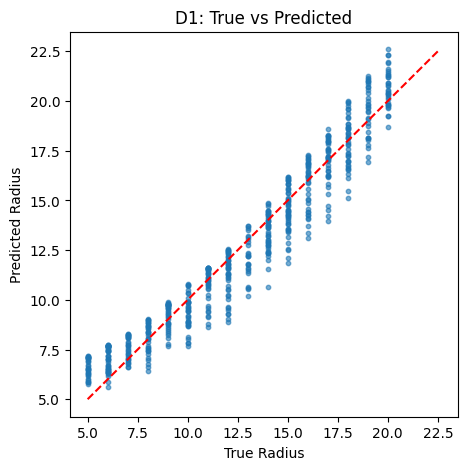

In [28]:
# Plot loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)

lims = [
    min(yte.min(), y_pred.min()),
    max(yte.max(), y_pred.max())
]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [1]:
pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfinrozzaqnirwanati","key":"7598337e59d29b398397cf36ed3759c2"}'}

In [4]:
import os, shutil
if os.path.exists("kaggle.json"):
 os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
 shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
 os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
 !pip -q install kaggle
 print("✅ Kaggle API siap digunakan.")
else:
 print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new -p "F:\Documents\Coding\Kuliah\SMT 3\Visi Komputer\Visi_Komputer_TI-2A_05\Jobsheet 3"

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors




  0%|          | 0.00/331M [00:00<?, ?B/s]
 41%|████▏     | 137M/331M [00:00<00:00, 1.44GB/s]
 83%|████████▎ | 275M/331M [00:00<00:00, 1.44GB/s]
100%|██████████| 331M/331M [00:00<00:00, 1.45GB/s]


In [5]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


In [ ]:
!unzip -q /content/utkface-new.zip -d /content/UTKFace

f:\Documents\Coding\Kuliah\SMT 3\Visi Komputer\Visi_Komputer_TI-2A_05\Jobsheet 3


Total gambar ditemukan: 23708


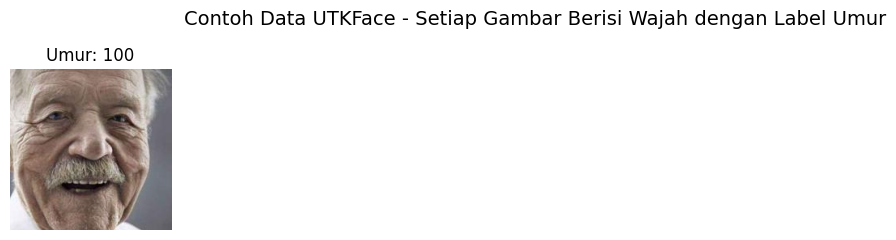

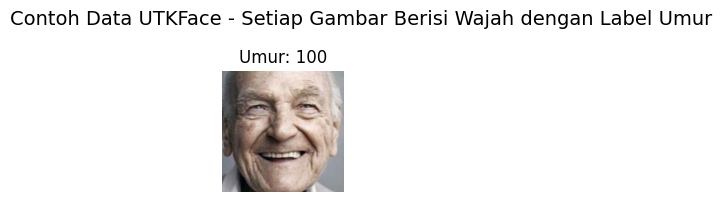

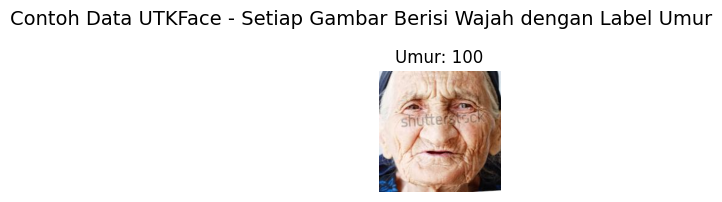

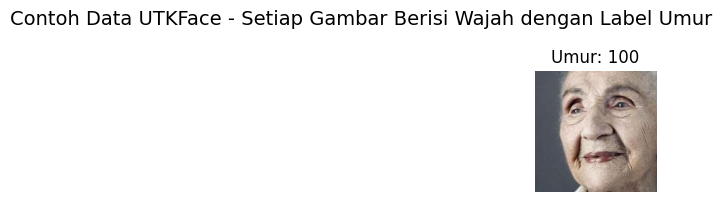

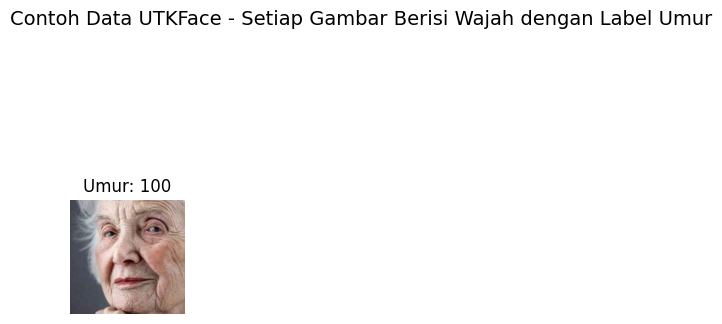

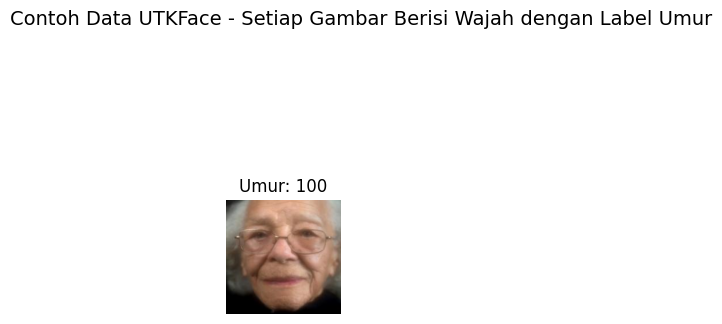

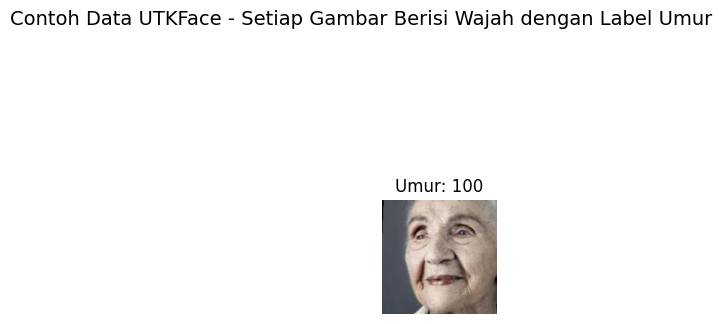

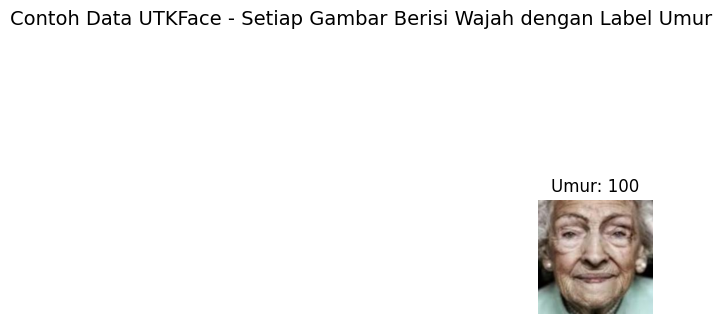

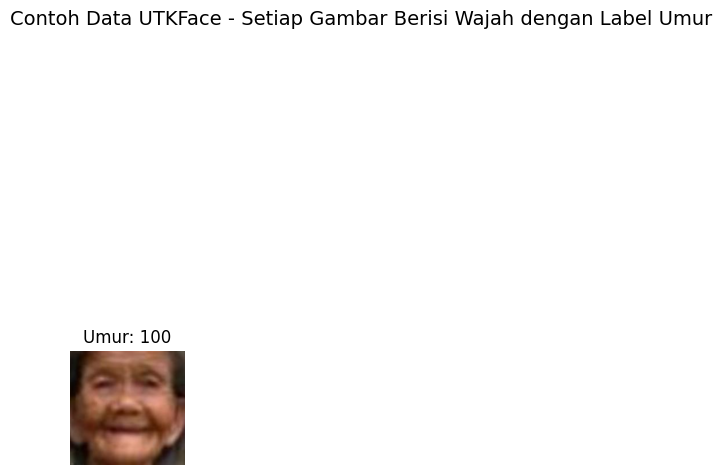

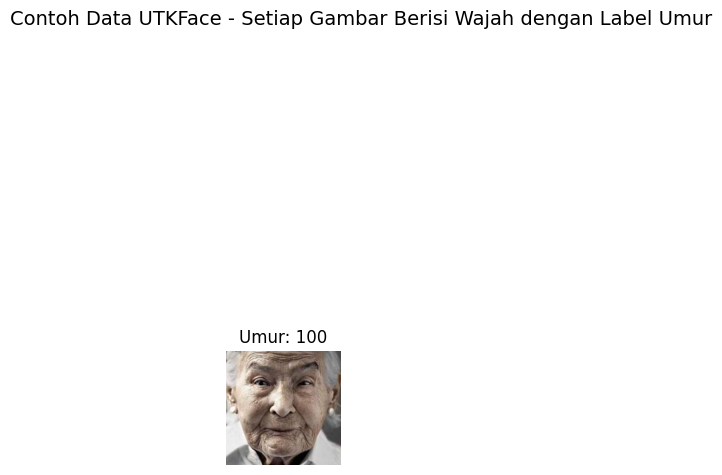

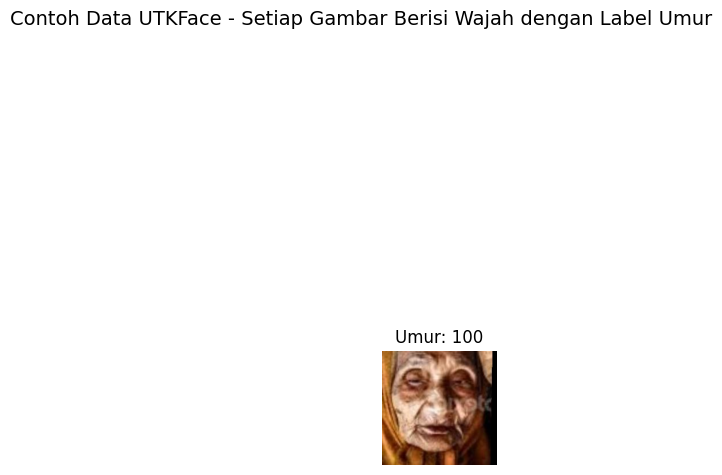

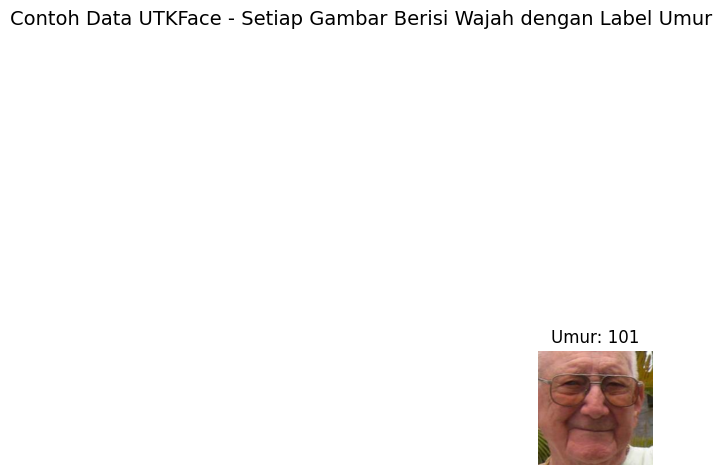

In [35]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
   age = int(os.path.basename(f).split("_")[0])
   img = Image.open(f)
   plt.subplot(3, 4, i + 1)
   plt.imshow(img)
   plt.title(f"Umur: {age}")
   plt.axis("off")
   plt.suptitle("Contoh Data UTKFace - Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
   plt.tight_layout()
   plt.show()

In [36]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
   return int(os.path.basename(fp).split('_')[0])
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
   img = tf.io.read_file(fp)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
   return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [37]:
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score

print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else  "CPU")

base_model = tf.keras.applications.MobileNetV2(
   include_top=False,
   input_shape=(IMG_SIZE, IMG_SIZE, 3),
   weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs*255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128,activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='mse',metrics=['mae'])
model.summary()


Hardware: GPU


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_4 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 67s 166ms/step - loss: 332.1953 - mae: 13.4123 - val_loss: 159.4678 - val_mae: 9.6232 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 155.0852 - mae: 9.2365 - val_loss: 146.5744 - val_mae: 9.0908 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 144.7566 - mae: 8.8831 - val_loss: 146.1532 - val_mae: 9.1211 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 140.4062 - mae: 8.7071 - val_loss: 138.0517 - val_mae: 8.6263 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 138.9490 - mae: 8.6159 - val_loss: 137.6315 - val_mae: 8.6997 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - loss: 136.3582 - mae: 8.5773 - val_loss: 136.4001 - val_mae: 8.6361 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 133.8212 - mae: 8.4271 - val_loss: 135.8311 - va

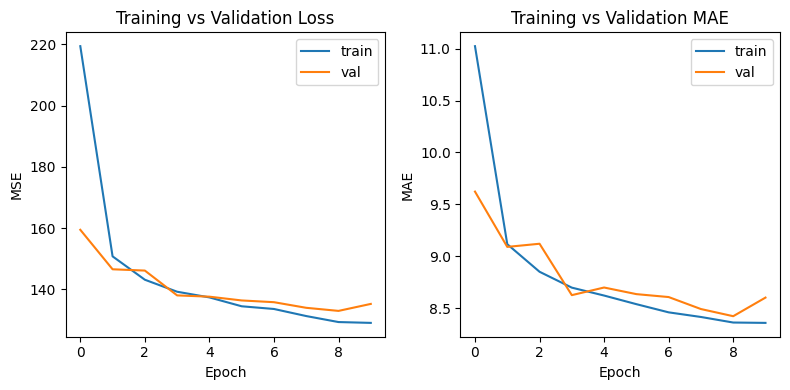

In [38]:
cb = [
   tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True,monitor='val_loss'),
   tf.keras.callbacks.ReduceLROnPlateau(patience=2,factor=0.5,min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
   train_ds,
   validation_data=test_ds,
   epochs=10,
   callbacks=cb,
   verbose=1
)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()





Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 89s 167ms/step - loss: 226.0207 - mae: 11.1073 - val_loss: 259.6281 - val_mae: 11.9425 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 77.0444 - mae: 6.5309 - val_loss: 131.8094 - val_mae: 8.3654 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 45.5763 - mae: 5.0982 - val_loss: 115.3963 - val_mae: 7.7421 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - loss: 32.3282 - mae: 4.2809 - val_loss: 99.7834 - val_mae: 7.4156 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 28.1077 - mae: 3.9250 - val_loss: 103.3249 - val_mae: 7.4069 - learning_rate: 1.0000e-04


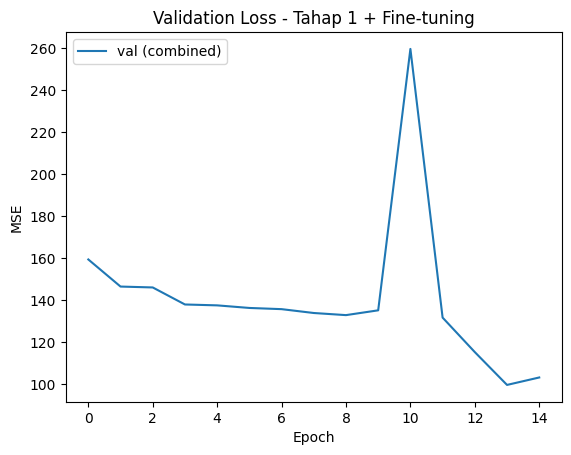

In [39]:
base_model.trainable = True
for layer in base_model.layers[:30]:
  layer.trainable = False
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])

history_ft = model.fit(
   train_ds,
   validation_data=test_ds,
   epochs=5,
   callbacks=cb,
   verbose=1
)

plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
         label='val (combined)')
plt.title("Validation Loss - Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

MAE = 7.42 tahun
RMSE = 9.99 tahun
R2 = 0.7486


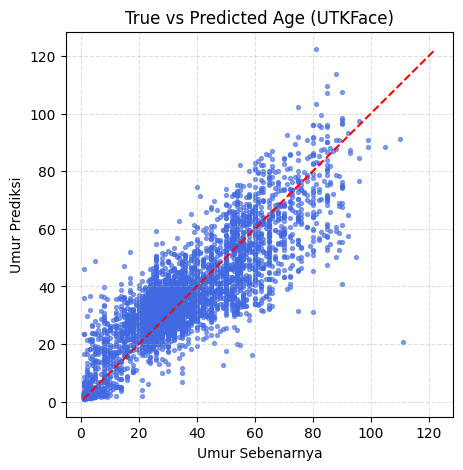

In [40]:
from math import sqrt
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.4f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel('Umur Sebenarnya')
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


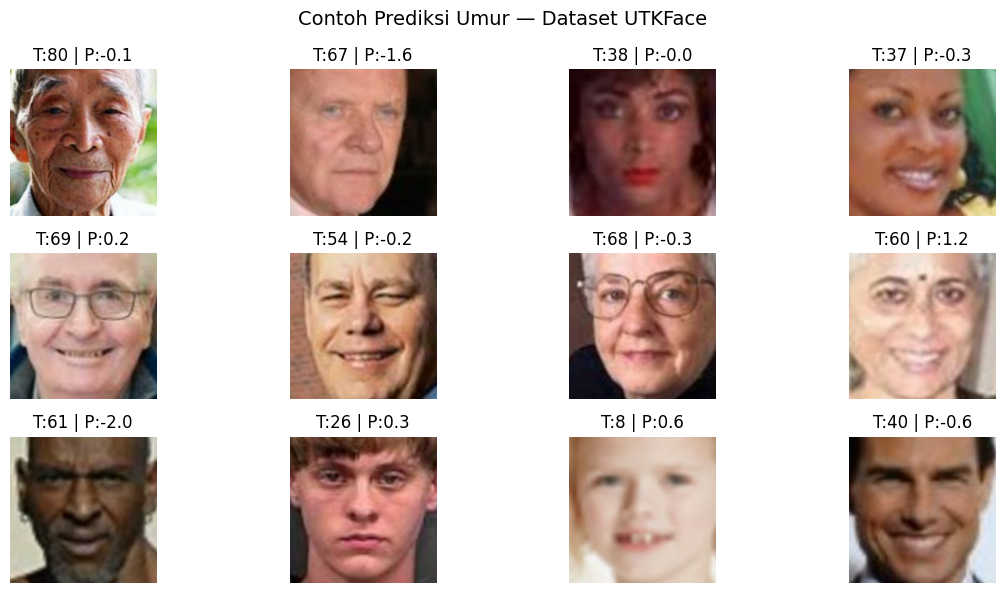

In [9]:
import random

sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))

for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto

In [13]:
from google.colab import files

# Upload kaggle.json dari komputer
files.upload()

import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (1).json
✅ Kaggle API siap digunakan.


In [15]:
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

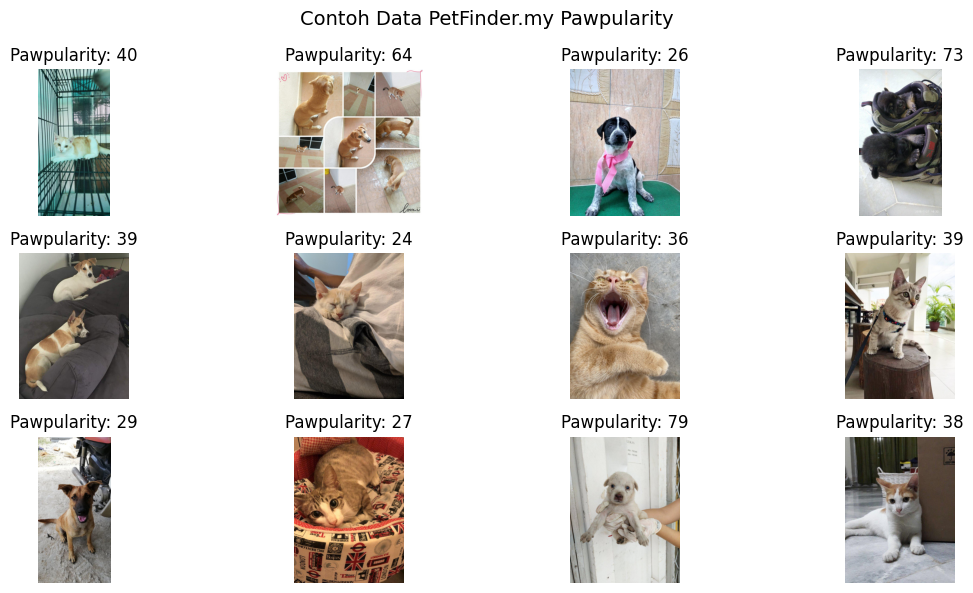

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))

for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

In [48]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

# Split dataset menjadi train dan validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Fungsi untuk memuat dan preprocessing gambar
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Dataset training
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4096)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset validation
val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"✅ Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

✅ Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


In [49]:
from tensorflow.keras import layers, models

# Load EfficientNetB0 sebagai base model
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

# Bangun model
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Ringkasan arsitektur
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_5 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [50]:
# Callback untuk training
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5
    )
]

# Training model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 79s 372ms/step - loss: 841.7340 - mae: 22.0653 - val_loss: 481.5640 - val_mae: 16.0374 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - loss: 421.6845 - mae: 15.0894 - val_loss: 433.0617 - val_mae: 15.5019 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - loss: 392.7588 - mae: 14.6457 - val_loss: 406.6033 - val_mae: 14.8363 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 46s 244ms/step - loss: 356.3485 - mae: 14.0119 - val_loss: 395.2160 - val_mae: 14.8197 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - loss: 355.2850 - mae: 13.9872 - val_loss: 381.9937 - val_mae: 14.1570 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 255ms/step - loss: 348.1721 - mae: 13.8717 - val_loss: 374.2856 - val_mae: 14.2248 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 79s 247ms/step - loss: 339.9731 - mae: 13.6967 - val_l

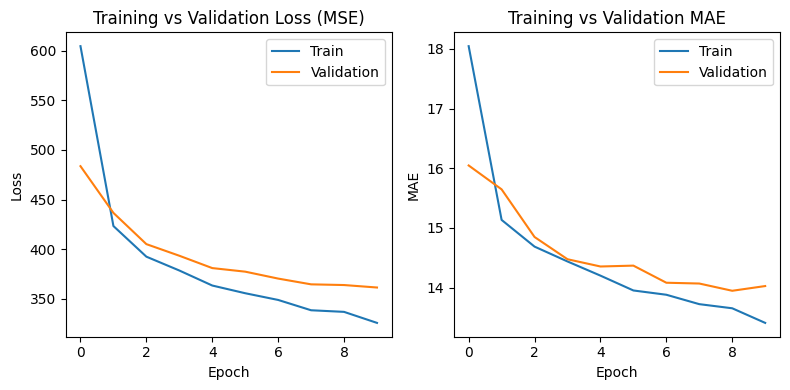

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()

MAE  = 14.03
RMSE = 19.01
R²   = 0.183


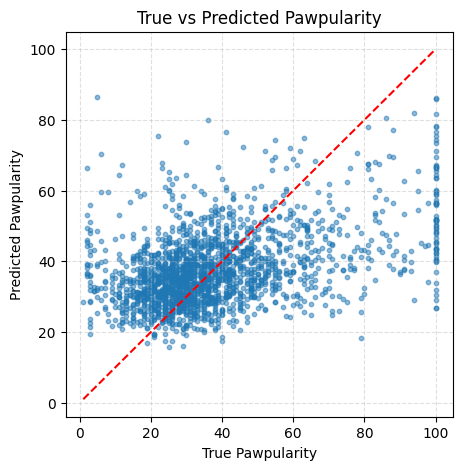

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# Ground truth dan prediksi
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([
    model.predict(batch[0], verbose=0).ravel()
    for batch in val_ds
])

# Hitung metrik evaluasi
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred) ** 2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)

lims = [
    min(y_true.min(), y_pred.min()),
    max(y_true.max(), y_pred.max())
]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

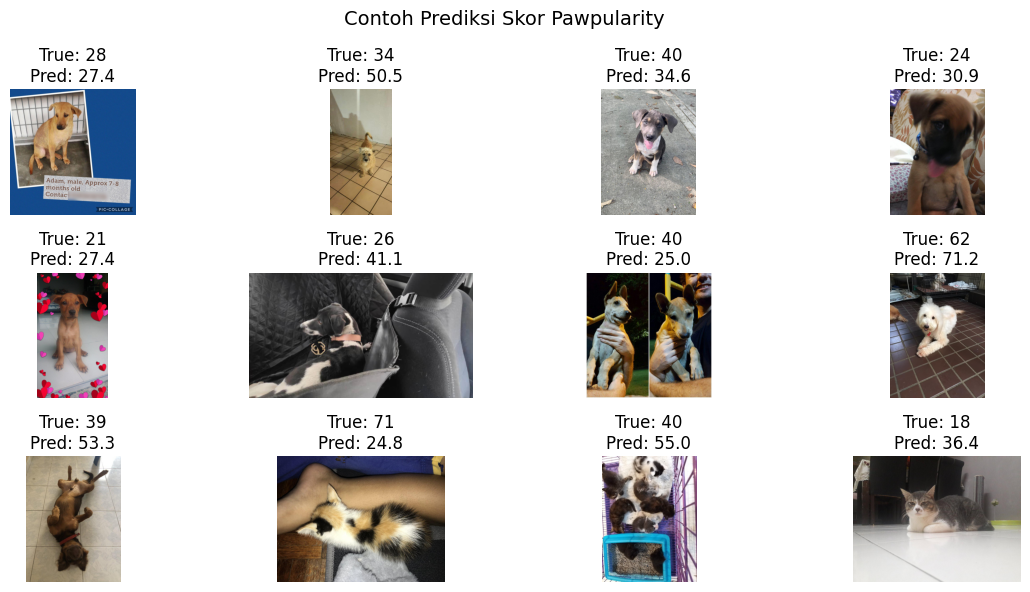

In [22]:
import random
from PIL import Image

# Ambil 12 sampel acak dari data validasi
sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12, 6))

for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(
        tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0),
        verbose=0
    ).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

Penugasan

Saving IMG_20250907_213119.jpg to IMG_20250907_213119 (1).jpg


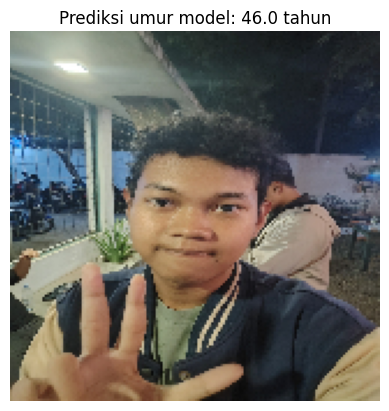

Hasil prediksi umur model: 46.0 tahun


In [46]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Upload foto pribadi
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Baca dan proses gambar
img = tf.io.read_file(filename)
img = tf.image.decode_image(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

# Gunakan preprocessing yang sesuai dengan MobileNetV2
img_proc = preprocess_input(img * 255.0)

# Prediksi umur (pastikan tidak negatif)
pred_age = float(model.predict(tf.expand_dims(img_proc, 0), verbose=0).ravel()[0])
pred_age = max(0, pred_age)  # agar tidak ada hasil negatif

# Tampilkan hasil
plt.imshow((img / 255.0).numpy())  # tampilkan versi asli, bukan yang sudah dipreprocess
plt.title(f"Prediksi umur model: {pred_age:.1f} tahun")
plt.axis("off")
plt.show()

print(f"Hasil prediksi umur model: {pred_age:.1f} tahun")


Saving IMG_20250602_155137.jpg to IMG_20250602_155137 (1).jpg


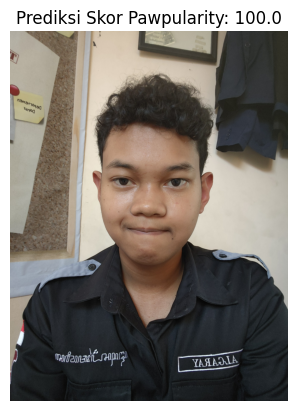

📸 Skor kepopuleran foto menurut model: 100.0 / 100


In [52]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# Upload foto pribadi hewan peliharaan (jpg/png)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Fungsi preprocessing gambar sesuai EfficientNetB0
def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img * 255.0)  # preprocessing khusus EfficientNet
    return img

# Proses gambar & prediksi
img = preprocess_image(filename)
pred_score = float(model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0])

# Batasi skor agar di rentang realistis (0–100)
pred_score = np.clip(pred_score, 0, 100)

# Tampilkan hasil
plt.imshow(tf.image.decode_image(tf.io.read_file(filename)))
plt.title(f"Prediksi Skor Pawpularity: {pred_score:.1f}")
plt.axis("off")
plt.show()

print(f"📸 Skor kepopuleran foto menurut model: {pred_score:.1f} / 100")
